In [1]:
from skimage.io.collection import ImageCollection
from skimage.io import imread
from skimage.color import rgb2gray
from joblib import Parallel,delayed
from typing import Tuple, List
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import ml_metrics as metrics
import cv2
import pickle
import os
import multiprocessing

In [2]:
# Choosing Number of Cores to use for multiprocessing
n_process = multiprocessing.cpu_count()

if n_process > 1 and n_process < 4:
    n_process = 2
elif n_process >= 4:
    n_process = 4
else:
    n_process = 1

In [3]:
"""
   Load images from DataBase and QuerySets
"""
def load_data() -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
   # We use ImageCollection to load all images inside folders
   db = ImageCollection("./data/BBDD/*.jpg")
   print('BBDD read: {} images'.format(len(db)))
   qs1 = ImageCollection("./data/qsd1_w1/*.jpg")
   print('QuerySet1 read: {} images'.format(len(qs1)))
   qs2 = ImageCollection("./data/qsd2_w1/*.jpg")
   print('QuerySet2 read: {} images'.format(len(qs2)))
    
   return db, qs1, qs2

In [4]:
"""
   Computes image's histograms for each color channel (r,g,b) and concatenates them
   to create a feature vector
"""
def get_histogram_vector(image: np.ndarray,n_bins: int = 16) -> np.ndarray:
   # Histogram calculation per Red, Green, Blue and Gray Channel using n_bins
   r_hist = np.histogram(image[:, :, 0],bins=n_bins)[0]
   g_hist = np.histogram(image[:, :, 1],bins=n_bins)[0]
   b_hist = np.histogram(image[:, :, 2],bins=n_bins)[0]
   gray_hist = np.histogram(rgb2gray(image),bins=n_bins)[0]
   
   # Normalize histograms
   r_hist = ((r_hist - np.min(r_hist)) / (np.max(r_hist) - np.min(r_hist))).astype(np.float32)
   g_hist = ((g_hist - np.min(g_hist)) / (np.max(g_hist) - np.min(g_hist))).astype(np.float32)
   b_hist = ((b_hist - np.min(b_hist)) / (np.max(b_hist) - np.min(b_hist))).astype(np.float32)
   gray_hist = ((gray_hist - np.min(gray_hist)) / (np.max(gray_hist) - np.min(gray_hist))).astype(np.float32)
   
   # Join all Histograms into a single feature vector
   feature_vector = np.hstack((r_hist,g_hist,b_hist,gray_hist))
   
   return feature_vector


"""
   Computes feature vector for each image of our dataset.
"""    
def get_feature_matrix(dataset: np.ndarray, desc: str, n_bins: int = 16) -> np.ndarray:
   # Build feature matrix applying get_histogram_vector over all images in dataset
   # We apply some multiprocessing so we can reduce processing time by half
   feature_matrix = Parallel(n_jobs=n_process)(delayed(get_histogram_vector)(image,n_bins)for image in tqdm(dataset,desc=desc))
   return np.array(feature_matrix)  

In [5]:
"""
   Computes cos similarity between feature vector and all BBDD feature vectors
"""    
def cos_similarity(vector: np.ndarray) -> np.ndarray:
   # We take profit of numpy broadcasting to calculate cos similarity between the provided vector and all BBDD features
   return db_feature_matrix.dot(vector)/ (np.linalg.norm(db_feature_matrix, axis=1) * np.linalg.norm(vector))


"""
   Computes euclidean similarity between feature vector and all BBDD feature vectors
"""   
def euclidean_similarity(vector: np.ndarray) -> np.ndarray:
   # We take profit of numpy broadcasting to calculate euclidean similarity between the vector and all BBDD features
   dist = (db_feature_matrix - vector)**2
   dist = np.sum(dist, axis=1)
   dist = np.sqrt(dist)
   dist = np.max(dist) - dist
   return dist


"""
   Computes histogram intersection for each channel between 2 feature vectors
"""
def compute_histogram_intersect_vector(vector1: np.ndarray, vector2: np.ndarray) -> np.ndarray:
   # Recover each channel and Calculate intersection
   n_bins = int(len(vector1)/4)
   r = np.sum(np.minimum(vector1[:n_bins], vector2[:n_bins]))
   g = np.sum(np.minimum(vector1[n_bins:2*n_bins], vector2[n_bins:2*n_bins]))
   b = np.sum(np.minimum(vector1[2*n_bins:3*n_bins], vector2[2*n_bins:3*n_bins]))
   gray = np.sum(np.minimum(vector1[3*n_bins:], vector2[3*n_bins:]))
   # Retrieve mean
   return np.mean([r,g,b,gray])


"""
   Computes histogram intersection for each channel between 2 feature vectors
"""
def histogram_similarity(vector1: np.ndarray) -> np.ndarray:
   return np.array([compute_histogram_intersect_vector(vector1,vector2) for vector2 in db_feature_matrix])


def compute_histogram_correlation_vector(vector1: np.ndarray, vector2: np.ndarray) -> np.ndarray:
   n_bins = int(len(vector1)/4)
   r = cv2.compareHist(vector1[:n_bins], vector2[:n_bins],cv2.HISTCMP_CORREL)
   g = cv2.compareHist(vector1[n_bins:2*n_bins], vector2[n_bins:2*n_bins],cv2.HISTCMP_CORREL)
   b = cv2.compareHist(vector1[2*n_bins:3*n_bins], vector2[2*n_bins:3*n_bins],cv2.HISTCMP_CORREL)
   gray = cv2.compareHist(vector1[3*n_bins:], vector2[3*n_bins:],cv2.HISTCMP_CORREL)
   return np.mean([r,g,b,gray])


"""
   Computes histogram correlation bewteen vector and BBDD feature vectors
"""
def correlation_similarity(vector1: np.ndarray) -> np.ndarray:
   return np.array([compute_histogram_correlation_vector(vector1,vector2) for vector2 in db_feature_matrix])


"""
   Computes similairty for an entire QuerySet
"""    
def compute_similarities(qs: np.ndarray,desc: str, similarity: str = 'cos') -> np.ndarray:
   # Perform similarity for each vector in the QuerySet
   if similarity == "cos":
      return np.array([cos_similarity(vector) for vector in tqdm(qs,desc=desc)])
   
   elif similarity == "intersection":
      return np.array([histogram_similarity(vector1=vector) for vector in tqdm(qs,desc=desc)])
   
   elif similarity == "euclidean":
      return np.array([euclidean_similarity(vector) for vector in tqdm(qs,desc=desc)])
   
   elif similarity == "correlation":
      return np.array([correlation_similarity(vector) for vector in tqdm(qs,desc=desc)])
   
   elif similarity == "mixed":
      return np.array([correlation_similarity(vector)+cos_similarity(vector) for vector in tqdm(qs,desc=desc)])
      

In [6]:
"""
   Retrieves the top k similar images for a vector.
"""    
def get_top_k_vector(similarity_vector: np.ndarray, k: int) -> List[str]:
   # We get top K index of the vector (unordered)
   idx = np.argpartition(similarity_vector, -k)[-k:]
   
   # Then we order index in order to get the ordered top k values
   top_k = list(similarity_vector[idx])
   sorted_top = list(sorted(top_k,reverse=True))
   idx = [idx[top_k.index(i)] for i in sorted_top]
   
   # ImageCollection also saves in .files so we can easily retrieve them
   return [db.files[i] for i in idx]


"""
   Retrieves the top k similar images for a QuerySEt
"""    
def get_top_k(similarity_matrix: np.ndarray, k: int, desc: str) -> List[List[str]]:
   # Estimate top k values for all the Queryet
   return [get_top_k_vector(vector,k) for vector in tqdm(similarity_matrix, desc = desc)]


"""
   Retrieves the top k similar images for a vector.
"""    
def get_bot_k_vector(similarity_vector: np.ndarray, k: int) -> List[str]:
   # We get bot K index of the vector (unordered)
   idx = similarity_vector.argsort()[:k]
   
   # Then we order index in order to get the ordered bot k values
   bot_k = list(similarity_vector[idx])
   sorted_bot = list(sorted(bot_k,reverse=False))
   idx = [idx[bot_k.index(i)] for i in sorted_bot]
   
   # ImageCollection also saves in .files so we can easily retrieve them
   return [db.files[i] for i in idx]


"""
   Retrieves the bot k similar images for a QuerySet.
"""    
def get_bot_k(similarity_matrix: np.ndarray, k: int, desc: str) -> List[List[str]]:
   # Estimate bot k values for all the Queryet
   return [get_bot_k_vector(vector,k) for vector in tqdm(similarity_matrix, desc = desc)]
 
 

In [7]:
"""
    Image path to ID
"""
def get_image_id(image: str) -> str:
    # Extract BBBD_XXX.jpg from relative path
    file = image.split("/")[3]
    # Extract XXX id from BBBD_XXX.jpg 
    id = file.replace(".jpg","").split("_")[1]
    return int(id)


"""
    Save Results properly formated
"""
def save_results(results: List[List[str]], path: str) -> None:
    # Vectorize function to apply to each element in results
    get_ids = np.vectorize(get_image_id)
    results = get_ids(results)
    
    # Creates Save Folder 
    if not os.path.exists(path):
        os.makedirs(path)
    
    # Saves data
    pickle.dump(obj = results,file = open(path+"/result.pkl","wb"))
    print("Results Saved!")
    return results


"""
   Plot 1st Query Results
"""   
def plot_image_and_similar() -> None:
    
    for i in range(30):
        f, axarr = plt.subplots(1,2, figsize=(10,10))
        base = qs1[i]
        query = imread(top_k_qs1[i][0])
        axarr[0].imshow(base)
        axarr[0].title.set_text("Base")
        axarr[1].imshow(query)
        axarr[1].title.set_text("Query")
        plt.show()

# QUERYSET 1 

In [8]:
# Load Data
db, qs1, qs2 = load_data()

# Feature extraction
db_feature_matrix = get_feature_matrix(dataset = db, n_bins = 16, desc = "Creating feature matrix for BBDD...(n_process = {})".format(n_process))
qs1_feature_matrix = get_feature_matrix(dataset = qs1, n_bins = 16, desc = "Creating feature matrix for QuerySet1...(n_process = {})".format(n_process))

# Similarity Computation
qs1_similarities = compute_similarities(qs = qs1_feature_matrix, desc = "Computing qs1 similarities...", similarity = 'correlation')

# Top K Estimation
top_k_qs1 = get_top_k(qs1_similarities, k = 10, desc = "Retrieving qs1 top K similar images...")

# Evaluation and Saving
predicted_results = save_results(top_k_qs1,"./week1/QST1/method1")
expected_results = pickle.load(open('./data/qsd1_w1/gt_corresps.pkl', "rb"))
metric = metrics.mapk(actual=expected_results,predicted=predicted_results,k=10)
print("MAP@K Score: {:.4f}% ({}/{})".format(metric*100,int(len(predicted_results)*metric),len(predicted_results)))


Creating feature matrix for BBDD...(n_process = 4):   1%|          | 2/287 [00:00<00:15, 18.99it/s]

BBDD read: 287 images
QuerySet1 read: 30 images
QuerySet2 read: 30 images


Creating feature matrix for BBDD...(n_process = 4): 100%|██████████| 287/287 [00:17<00:00, 16.68it/s]
Creating feature matrix for QuerySet1...(n_process = 4): 100%|██████████| 30/30 [00:00<00:00, 81.34it/s]
Retrieving qs1 top K similar images...: 100%|██████████| 30/30 [00:00<00:00, 282.67it/s]

Results Saved!
MAP@K Score: 44.6111% (13/30)


# Queryset 2

Based on [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) a thresholding color method.
The algorithm exhaustively searches for the threshold that minimizes the intra-class variance, defined as a weighted sum of variances of the two classes:

<img src="https://miro.medium.com/max/1400/1*GQNVs_s3g9QshW3uco7dvA.png"
     alt="https://miro.medium.com/max/1400/1*GQNVs_s3g9QshW3uco7dvA.png"
     style="float: left; margin-right: 10px;max-height:600px; max-width:600px" />


In [9]:
def otsus_binarization(gray_image: np.ndarray) -> float:

    # Histogram
    hist, bin_edges = np.histogram(gray_image, bins=256)

    # Medium from bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    # Get the probabilities w1(t), w2(t) with the accumulative probability/distribution of intensities
    w1 = np.cumsum(hist)
    w2 = np.cumsum(hist[::-1])[::-1]

    # Class 1 Mean
    sigma1 = np.cumsum(hist * bin_mids) / w1
    
    # Class 2 Mean
    sigma2 = (np.cumsum((hist * bin_mids)[::-1]) / w2[::-1])[::-1]

    # Variances
    variance_between_classes = w1[:-1] * w2[1:] * (sigma1[:-1] - sigma2[1:]) ** 2

    # Maximize the inter_class_variance function val aka the threshold
    idx_max_variance = np.argmax(variance_between_classes)
    th = bin_mids[:-1][idx_max_variance]
    
    # print("Threshold found: {} ({} if not normalized)".format(th,th*255))
    
    # Generate Mask
    gray_image[gray_image >= th] = 1
    gray_image[gray_image <= th] = 0
    
    
    return gray_image


def crop_image(mask: np.ndarray) -> List[List[int]]:
    mid_i, mid_j = int(mask.shape[0]/2),int(mask.shape[1]/2)
    offset = 50
    
    mid_row = mask[mid_i,:]
    mid_col = mask[:,mid_j]
    
    left = np.where(mid_row == 0)[0][0]
    right = np.where(mid_row == 0)[0][-1]
    top = np.where(mid_col == 0)[0][0]
    bot = np.where(mid_col == 0)[0][-1]
    
    new_mask = np.zeros_like(mask)
    new_mask[top:bot,left:right] = 1
    
    return new_mask, (top,bot,left,right)


def crop_image_2(mask: np.ndarray) -> List[List[int]]:
    # Mid Column and Mid Row
    mid_i, mid_j = int(mask.shape[0]/2),int(mask.shape[1]/2)
    mid_row = mask[mid_i,:]
    mid_col = mask[:,mid_j]
    # Offset to initial points
    offset = 50
    th = 0.15
    
    top = None
    bot = None
    left = None
    right = None
    
    # Search left boundary
    found = False
    i = offset
    

    while not found:
        if abs(mid_row[i] - mid_row[i-1]) >= th: 
            found = True
            left = i
        i += 1


    # Search right boundary
    found = False
    i = mid_row.shape[0] - 1
    while not found:
        if abs(mid_row[i] - mid_row[i-1]) >= th:
            found = True
            right = i
        i -= 1


    # Search top boundary
    found = False
    j = 0
    while not found:
        if abs(mid_col[j] - mid_col[j-1]) >= th:
            found = True
            top = j
        j += 1

    # Search bot boundary
    found = False
    j = mid_col.shape[0] - 1
    while not found:
        if abs(mid_col[j] - mid_col[j-1]) >= th:
            found = True
            bot = j
        j -= 1

    new_mask = np.zeros_like(mask)
    new_mask[top:bot,left:right] = 1

    return new_mask, (top,bot,left,right)



def crop_images(qs: np.ndarray, method: str) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    masks, cropped_images = [], []
    
    if method == "otsu":
        for image in tqdm(qs, desc= "Cropping Images using Otsu method..."):
            im = otsus_binarization(rgb2gray(image))
            mask, coords = crop_image(im)
            cropped_image = image[coords[0]:coords[1], coords[2]:coords[3],:]
            masks.append(mask)
            cropped_images.append(cropped_image)
                    
    elif method == "diff":
        for image in tqdm(qs, desc= "Cropping Images using Pixel Diff method..."):
            im = rgb2gray(image)
            try:
                mask, coords = crop_image_2(im)
                cropped_image = image[coords[0]:coords[1], coords[2]:coords[3]]
            except:
                mask = np.zeros_like(image)
                mask[int(mask.shape[0]*0.25):,:,:] = [1,1,1]
                mask[int(mask.shape[0]*0.75):,:] = [1,1,1]
                mask[:,:int(mask.shape[1]*0.25),:] = [1,1,1]
                mask[:,int(mask.shape[1]*0.75):,:] = [1,1,1]
                cropped_image = image[int(image.shape[0]*0.25):int(image.shape[0]*0.75),int(image.shape[1]*0.25):int(image.shape[1]*0.75),:]
            
            masks.append(mask)
            cropped_images.append(cropped_image)
            

                
    return cropped_images, masks

In [10]:
def iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def prec_recall (true_labels, pred_labels):
    
    true_labels = np.asarray(true_labels).astype(np.bool)
    pred_labels = np.asarray(pred_labels).astype(np.bool)
    
    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

    precision = TP / (TP+FP)
    recall    = TP / (TP+FN)
    return precision, recall
    

def f1_dice(im1, im2):
    """
    Source: https://gist.github.com/JDWarner/6730747
    
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [11]:
def show_scores(masks: np.ndarray) -> None:
    evaluation_masks = ImageCollection("./data/qsd2_w1/*.png")
    f1, iou, prec, recall = [], [], [], []
    for i in range(len(masks)):
        gt_mask = evaluation_masks[i]
        mask = masks[i]
        try:
            f1.append(f1_dice(gt_mask, mask))
            iou.append(iou_score(gt_mask, mask))
            p , r = prec_recall(gt_mask, mask)
            prec.append(p)
            recall.append(r)
        except:
            pass
    
    print (f'IOU: {np.mean(iou)} - F1: {np.mean(f1)}  - Prec: {np.mean(prec)} - Recall:_ {np.mean(recall)}')
    
"""
   Plot 1st Query Results
"""   
def plot_image_and_similar() -> None:
    
    for i in range(30):
        f, axarr = plt.subplots(1,2, figsize=(10,10))
        base = new_qs2_1[i]
        query = imread(top_k_qs2_1[i][0])
        axarr[0].imshow(base)
        axarr[0].title.set_text("Base")
        axarr[1].imshow(query)
        axarr[1].title.set_text("Query")
        plt.show()


def save_masks(masks):
    for i in range(len(masks)):
        mask = masks[i]
        name = qs2.files[i]
        cv2.imwrite("", mask)
        

In [12]:
# QUERYSET 2 
# Load Data
db, qs1, qs2 = load_data()

new_qs2_1, masks_1 = crop_images(qs2,method="otsu")
new_qs2_2, masks_2 = crop_images(qs2,method="diff")

# Feature extraction
db_feature_matrix = get_feature_matrix(dataset = db, n_bins = 16, desc = "Creating feature matrix for BBDD...(n_process = {})".format(n_process))
qs2_1_feature_matrix = get_feature_matrix(dataset = new_qs2_1, n_bins = 16, desc = "Creating feature matrix for QuerySet2_1...(n_process = {})".format(n_process))
qs2_2_feature_matrix = get_feature_matrix(dataset = new_qs2_2, n_bins = 16, desc = "Creating feature matrix for QuerySet2_2...(n_process = {})".format(n_process))


# Similarity Computation
qs2_1_similarities = compute_similarities(qs = qs2_1_feature_matrix, desc = "Computing qs2_1 similarities...", similarity = 'correlation')
qs2_2_similarities = compute_similarities(qs = qs2_2_feature_matrix, desc = "Computing qs2_2 similarities...", similarity = 'correlation')


# Top K Estimation
top_k_qs2_1 = get_top_k(qs2_1_similarities, k = 10, desc = "Retrieving qs2_1 top K similar images...")
top_k_qs2_2 = get_top_k(qs2_2_similarities, k = 10, desc = "Retrieving qs2_2 top K similar images...")

# Evaluation and Saving
predicted_results_1 = save_results(top_k_qs2_1,"./week1/QST2/method1")
predicted_results_2 = save_results(top_k_qs2_2,"./week1/QST2/method2")

expected_results = pickle.load(open('./data/qsd2_w1/gt_corresps.pkl', "rb"))
frames = pickle.load(open('./data/qsd2_w1/frames.pkl', "rb"))
metric = metrics.mapk(actual=expected_results,predicted=predicted_results_1,k=10)
print("MAP@K Score(ostsu): {:.4f}% ({}/{})".format(metric*100,int(len(predicted_results)*metric),len(predicted_results)))
metric = metrics.mapk(actual=expected_results,predicted=predicted_results_2,k=10)
print("MAP@K Score(pixel diff): {:.4f}% ({}/{})".format(metric*100,int(len(predicted_results)*metric),len(predicted_results)))
show_scores(masks_1)
show_scores(masks_2)

Cropping Images using Otsu method...:   0%|          | 0/30 [00:00<?, ?it/s]

BBDD read: 287 images
QuerySet1 read: 30 images
QuerySet2 read: 30 images


Cropping Images using Pixel Diff method...: 100%|██████████| 30/30 [00:00<00:00, 36.53it/s]
Creating feature matrix for BBDD...(n_process = 4): 100%|██████████| 287/287 [00:14<00:00, 19.79it/s]
Creating feature matrix for QuerySet2_1...(n_process = 4): 100%|██████████| 30/30 [00:00<00:00, 111.86it/s]
Creating feature matrix for QuerySet2_2...(n_process = 4): 100%|██████████| 30/30 [00:00<00:00, 103.54it/s]
Retrieving qs2_2 top K similar images...: 100%|██████████| 30/30 [00:00<00:00, 31007.67it/s]


Results Saved!
Results Saved!
MAP@K Score(ostsu): 46.9444% (14/30)
MAP@K Score(pixel diff): 38.9444% (11/30)
IOU: 0.8715745710853717 - F1: 0.9265710273130439  - Prec: 0.9021938460067962 - Recall:_ 0.9594572569264126
IOU: 0.8585308214736943 - F1: 0.910722737124292  - Prec: 0.9533019872170455 - Recall:_ 0.8941028339855829


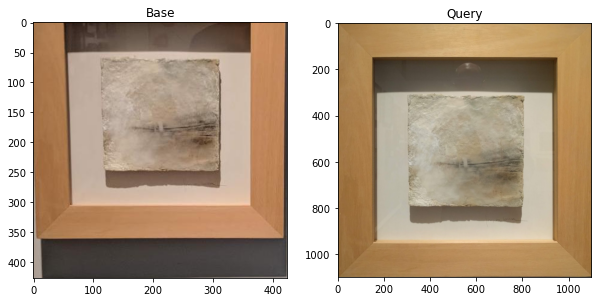

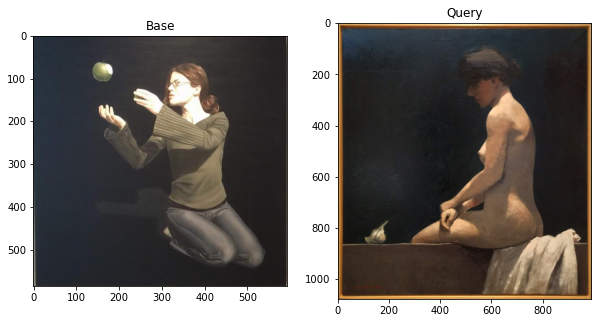

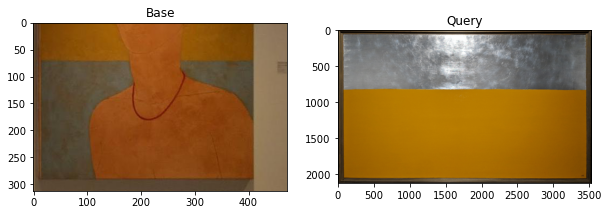

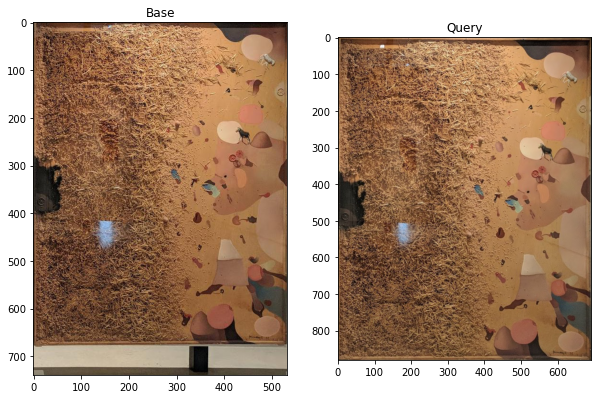

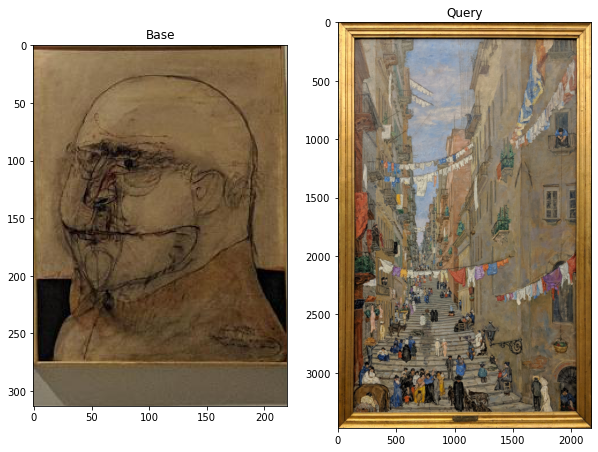

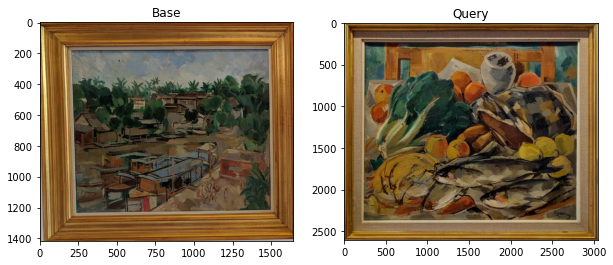

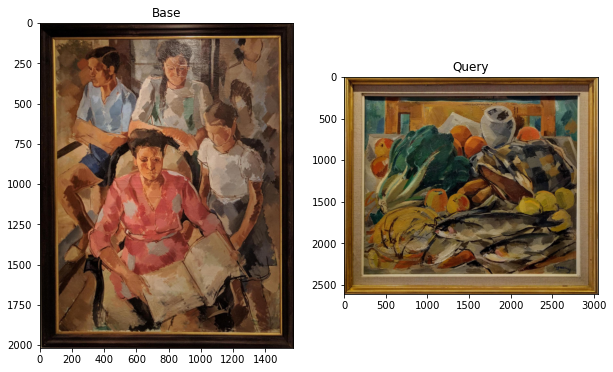

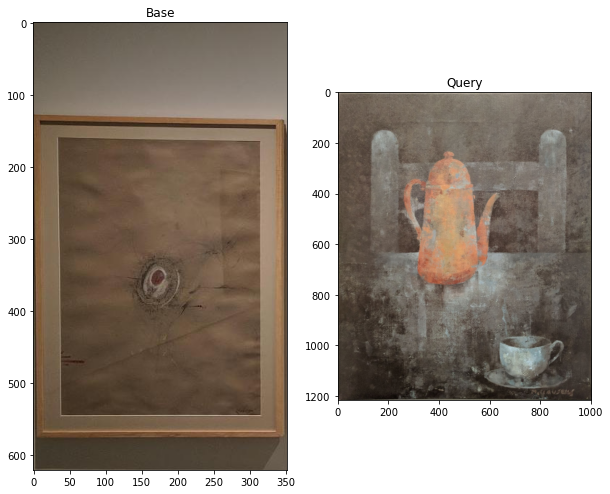

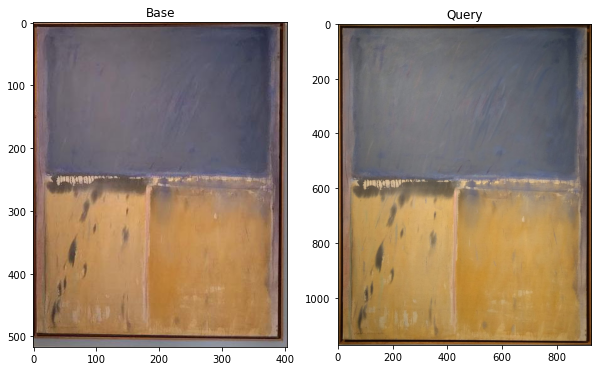

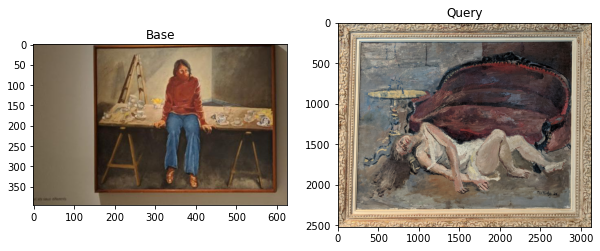

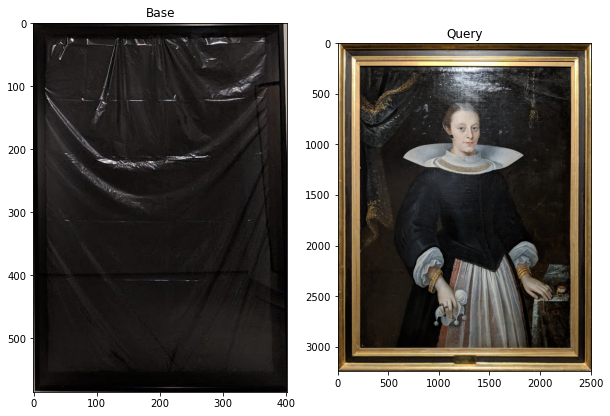

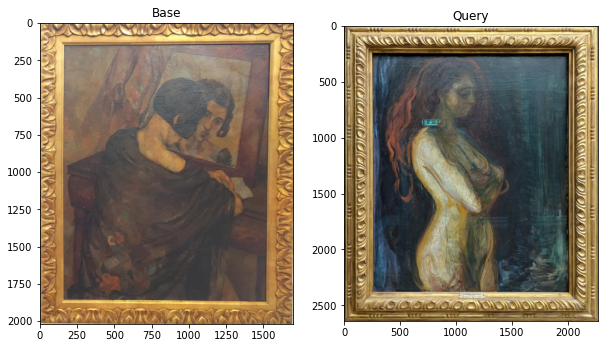

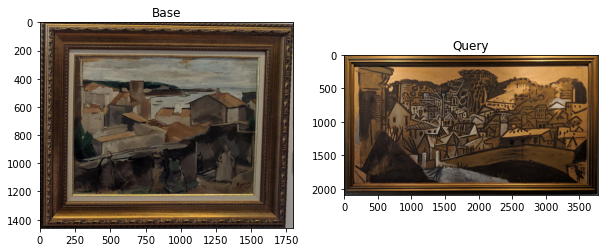

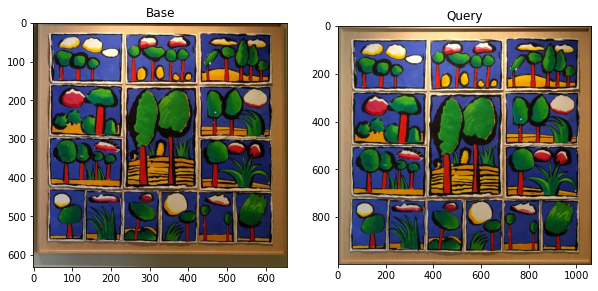

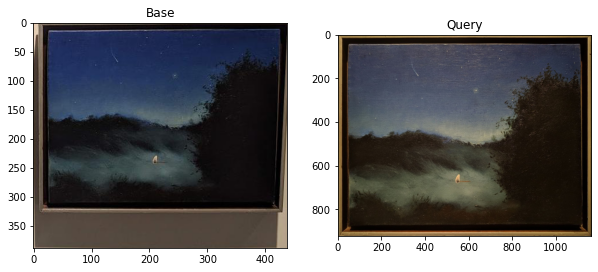

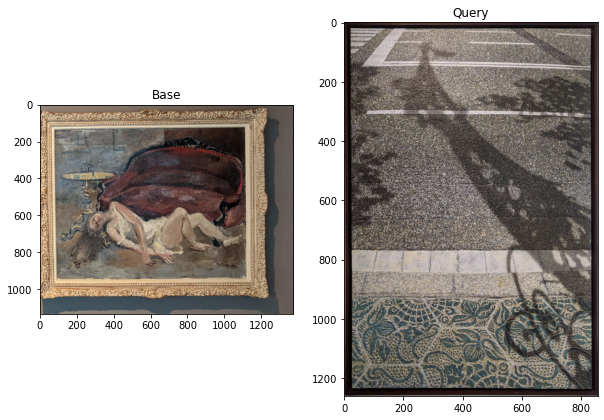

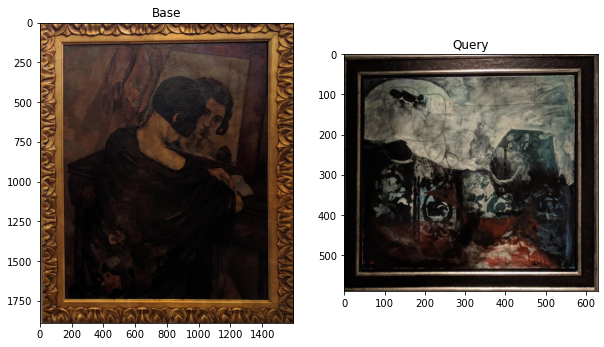

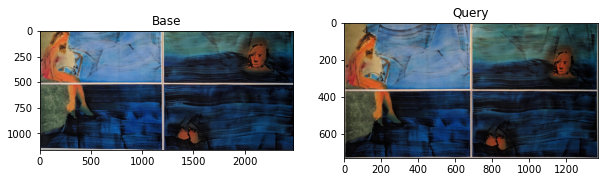

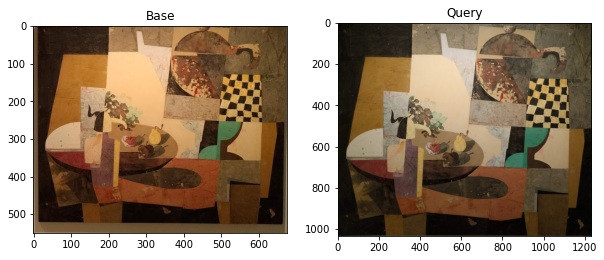

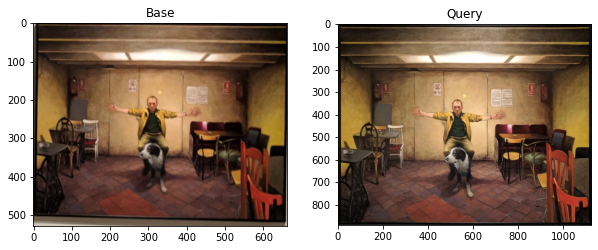

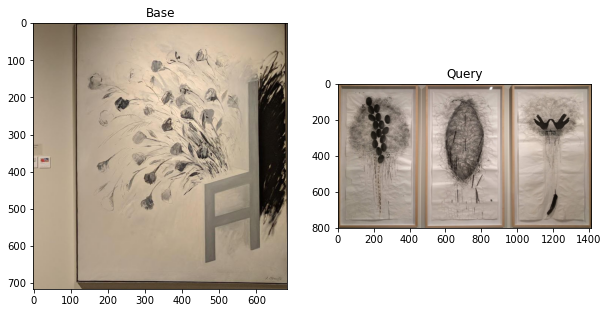

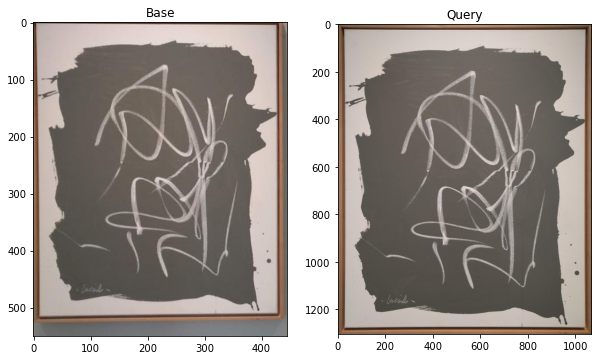

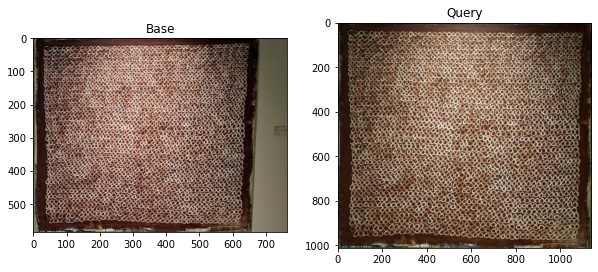

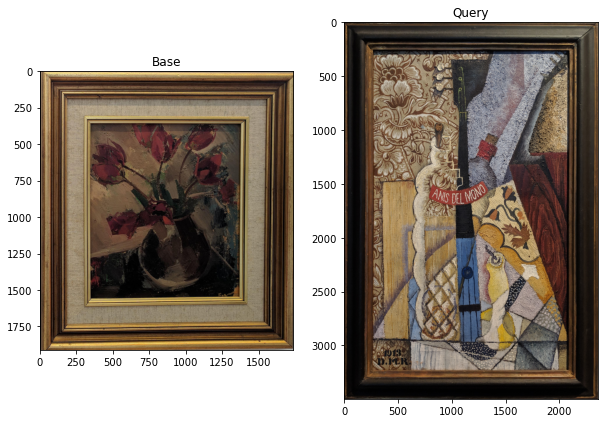

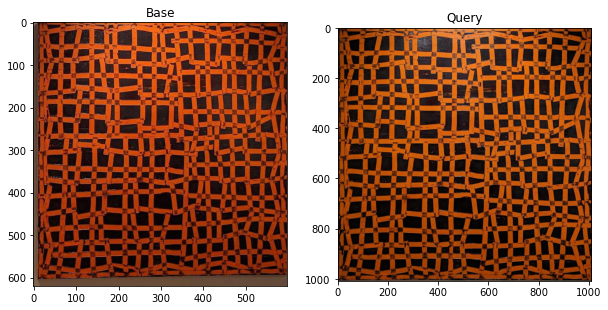

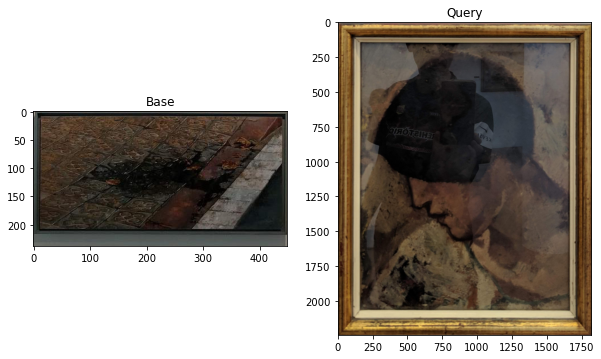

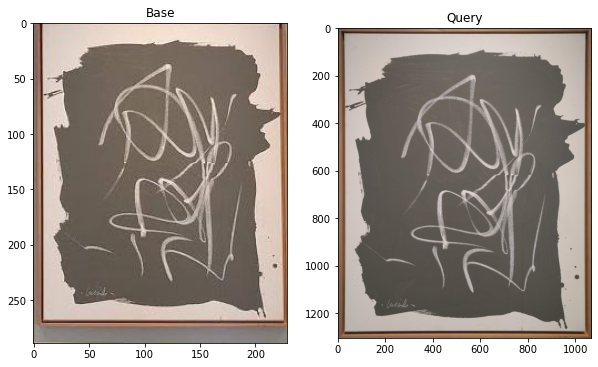

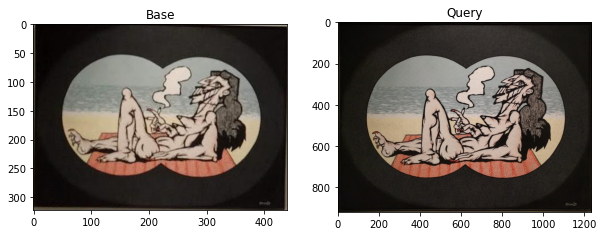

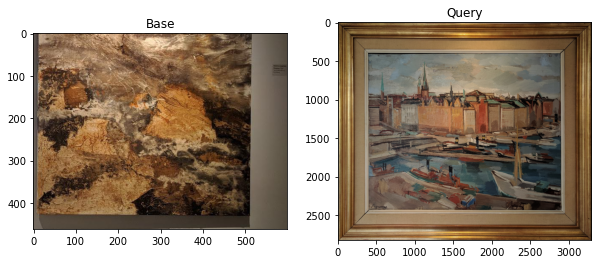

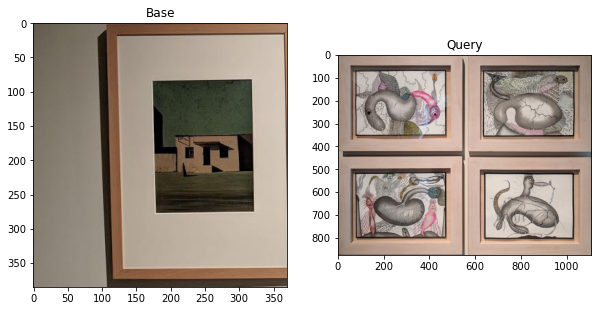

In [13]:
plot_image_and_similar()